# **Imports**

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt


# **SDF Functions**

In [4]:
# Signed distance function (SDF) for a sphere
def sphere(r):
    def sdf(p):
        length_p = torch.norm(p, dim=-1)
        d = length_p - r
        return d
    return sdf


**Neural SDF**

In [5]:
import torch
import torch.nn as nn
import numpy as np
class ImplicitNetwork(nn.Module):
    def __init__(
            self,
            feature_vector_size,
            d_in,
            d_out,
            dims,
            geometric_init=True,
            bias=1.0,
            skip_in=(),
            weight_norm=True,
            multires=0
    ):
        super().__init__()

        self.feature_vector_size = feature_vector_size
        dims = [d_in] + dims + [d_out + feature_vector_size]

        self.embed_fn = None
        if multires > 0:
            # Assuming get_embedder is defined elsewhere
            embed_fn, input_ch = get_embedder(multires)
            self.embed_fn = embed_fn
            dims[0] = input_ch

        self.num_layers = len(dims)
        self.skip_in = skip_in

        for l in range(0, self.num_layers - 1):
            if l + 1 in self.skip_in:
                out_dim = dims[l + 1] - dims[0]
            else:
                out_dim = dims[l + 1]

            lin = nn.Linear(dims[l], out_dim)

            if geometric_init:
                if l == self.num_layers - 2:
                    torch.nn.init.normal_(lin.weight, mean=np.sqrt(np.pi) / np.sqrt(dims[l]), std=0.0001)
                    torch.nn.init.constant_(lin.bias, -bias)
                elif multires > 0 and l == 0:
                    torch.nn.init.constant_(lin.bias, 0.0)
                    torch.nn.init.constant_(lin.weight[:, 3:], 0.0)
                    torch.nn.init.normal_(lin.weight[:, :3], 0.0, np.sqrt(2) / np.sqrt(out_dim))
                elif multires > 0 and l in self.skip_in:
                    torch.nn.init.constant_(lin.bias, 0.0)
                    torch.nn.init.normal_(lin.weight, 0.0, np.sqrt(2) / np.sqrt(out_dim))
                    torch.nn.init.constant_(lin.weight[:, -(dims[0] - 3):], 0.0)
                else:
                    torch.nn.init.constant_(lin.bias, 0.0)
                    torch.nn.init.normal_(lin.weight, 0.0, np.sqrt(2) / np.sqrt(out_dim))

            if weight_norm:
                lin = nn.utils.weight_norm(lin)

            setattr(self, "lin" + str(l), lin)

        self.softplus = nn.Softplus(beta=100)

    def forward(self, input, compute_grad=False):
        if self.embed_fn is not None:
            input = self.embed_fn(input)

        x = input

        for l in range(0, self.num_layers - 1):
            lin = getattr(self, "lin" + str(l))

            if l in self.skip_in:
                x = torch.cat([x, input], 1) / np.sqrt(2)

            x = lin(x)

            if l < self.num_layers - 2:
                x = self.softplus(x)
        return x

    def gradient(self, x):
        x.requires_grad_(True)
        y = self.forward(x)[:, :1]
        d_output = torch.ones_like(y, requires_grad=False, device=y.device)
        gradients = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=d_output,
            create_graph=True,
            retain_graph=True,
            only_inputs=True)[0]
        return gradients.unsqueeze(1)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

feature_vector_size = 0
d_in = 3
d_out = 1
dims = [32]

net = ImplicitNetwork(feature_vector_size, d_in, d_out, dims)
print(net.parameters)
# Define the sphere function using the SDFNet
def custom_sdf(r):
    def sdf(p):
        return net(p)  # Adjust the signed distance calculation
    return sdf

<bound method Module.parameters of ImplicitNetwork(
  (lin0): Linear(in_features=3, out_features=32, bias=True)
  (lin1): Linear(in_features=32, out_features=1, bias=True)
  (softplus): Softplus(beta=100, threshold=20.0)
)>


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


# **Ray Marcher**

In [7]:
import torch

class SphereTracing(torch.autograd.Function):

    def forward(
        self,
        sdf_func,
        ray_start,
        ray_dir,
        max_steps,
        epsilon,
        active_mask=None,
        bounding_sphere=None,
        *params,
    ):
        if active_mask is None:
            active_mask = torch.all(torch.isfinite(ray_start), dim=-1, keepdim=True)

        if bounding_sphere:
            a = torch.sum(ray_dir * ray_dir, dim=-1, keepdim=True)
            b = 2 * torch.sum(ray_dir * ray_start, dim=-1, keepdim=True)
            c = torch.sum(ray_start * ray_start, dim=-1, keepdim=True) - bounding_sphere ** 2
            discriminant = b ** 2 - 4 * a * c
            t_sphere = (-b - torch.sqrt(discriminant)) / (2 * a)
            within_sphere = discriminant >= 0
            ray_start = torch.where(within_sphere, ray_start + ray_dir * t_sphere, ray_start)
            active_mask = active_mask & within_sphere

        with torch.no_grad():
            for i in range(max_steps):
                distances = sdf_func(ray_start)
                distances = distances.unsqueeze(-1)

                if i > 0:
                    ray_start = torch.where(active_mask & ~done_mask, ray_start + ray_dir * distances, ray_start)
                else:
                    ray_start = torch.where(active_mask, ray_start + ray_dir * distances, ray_start)

                if bounding_sphere:
                    inside_bounds = torch.norm(ray_start, dim=-1, keepdim=True) < bounding_sphere
                    active_mask = active_mask & inside_bounds

                done_mask = torch.abs(distances) < epsilon
                if torch.all(~active_mask | done_mask):
                    break

        return ray_start, done_mask


# **Render**

In [8]:
# Sphere tracing function using the provided signature
def sphere_tracing(sdf, ray_pos, ray_dir, n_iter, conv_thresh, fg_masks=None, bound_radius=None):
    return SphereTracing.apply(sdf, ray_pos, ray_dir, n_iter, conv_thresh, fg_masks, bound_radius)


In [9]:
# Render a 2D image using sphere tracing
def render_image(sdf, img_size, fov, sphere_radius, num_iterations=100, convergence_threshold=1e-3):
    aspect_ratio = img_size[1] / img_size[0]
    pixel_coords = torch.stack(torch.meshgrid(
        torch.linspace(-1, 1, img_size[0]),
        torch.linspace(-aspect_ratio, aspect_ratio, img_size[1])
    ), dim=-1).reshape(-1, 2)

    # Ray origin and direction
    ray_origin = torch.tensor([0, 0, -5.0])  # Camera position
    fov_tensor = torch.tensor(fov)  # Convert FOV to tensor
    ray_directions = torch.cat([pixel_coords, torch.ones(len(pixel_coords), 1) * (1.0 / torch.tan(fov_tensor / 2))], dim=-1)
    ray_directions = ray_directions / torch.norm(ray_directions, dim=-1, keepdim=True)

    # Perform sphere tracing using the SphereTracing class
    traced_points, _ = sphere_tracing(sdf, ray_origin, ray_directions, num_iterations, convergence_threshold)

    # Convert traced points to an image (distance to the camera)
    distances = torch.norm(traced_points - ray_origin, dim=-1).reshape(img_size[0], img_size[1]).detach().numpy()

    return distances


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


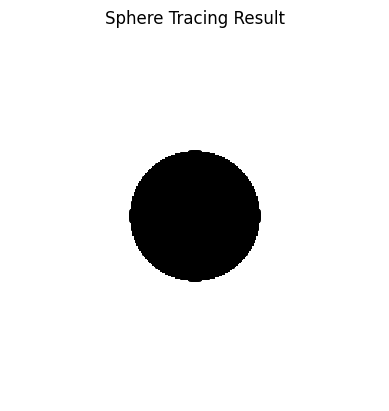

In [10]:
# Parameters
sphere_radius = 1.0
img_size = (256, 256)
fov = torch.pi / 3  # 60 degree field of view

# Create the sphere SDF
sdf = sphere(sphere_radius)

# Render the image
image = render_image(sdf, img_size, fov, sphere_radius)

# Display the result
plt.imshow(image, cmap='gray')
plt.title('Sphere Tracing Result')
plt.axis('off')
plt.show()
